<font size="+3"><strong>A/B Testing for Distance Learning Program Enrollment Optimization </strong></font>

This notebook delivers a data-driven framework for analyzing enrollment behavior in a popular Distance Learning Program, with direct implications for conversion strategy and ROI on outreach efforts. By integrating NoSQL data extraction from MongoDB, dynamic visualizations, and inferential statistical methods—including A/B testing, chi-square analysis, and odds ratio estimation—it quantifies the impact of admissions quiz completion on actual enrollments. Leveraging Python tools like pymongo, pandas, plotly, and statsmodels, the analysis connects backend data with actionable insights. Crucially, it informs whether investing in email campaigns to applicants who haven't completed their quiz will yield meaningful enrollment returns—turning raw data into strategic clarity.

In [1]:
from pymongo import MongoClient
from pymongo.collection import Collection
from ab_test import Reset

r = Reset()
r.reset_database()

Client type: <class 'pymongo.synchronous.mongo_client.MongoClient'>


{'applicants': {'matched': 18, 'modified': 18}}

In [2]:
# Import your libraries here
import random
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import scipy
from statsmodels.stats.contingency_tables import Table2x2
from statsmodels.stats.power import GofChisquarePower
from ab_test import Experiment
from ab_test import Reset
from country_converter import CountryConverter

# Connect

Check and connect to the MongoDB server, then select the relevant collection

In [32]:
# Create `client`
client = MongoClient(host='localhost', port=27017)
# Create `db`
db = client["online_course"]
# Assign `"applicants"` collection to `applicant`
applicants = db["applicants"]

# Explore

Aggregate the applicants by nationality, and then load results into the DataFrame

In [4]:
# Aggregate applicants by nationality
result = applicants.aggregate(
    [
        {
            "$group":{
                "_id": "$countryISO2", "count": {"$count":{}}
            }
        }
    ]
)

# Load result into DataFrame
df_nationality =  pd.DataFrame(result).rename({"_id": "country_iso2"}, axis="columns").sort_values("count")

print("df_nationality type:", type(df_nationality))
print("df_nationality shape", df_nationality.shape)
df_nationality.head()

df_nationality type: <class 'pandas.core.frame.DataFrame'>
df_nationality shape (39, 2)


,country_iso2,count
24,AE,34
13,GH,37
38,KE,39
34,MA,45
32,CL,45


Using the `country_converter` library, add two new columns to `df_nationality`.

In [5]:
# Instantiate `CountryConverter`
cc = CountryConverter()
# Create `"country_name"` column
df_nationality["country_name"] = cc.convert(
    df_nationality["country_iso2"], to = "name_short"
)
# Create `"country_iso3"` column
df_nationality["country_iso3"] = cc.convert(df_nationality["country_iso2"], to = "ISO3")

print("df_nationality type:", type(df_nationality))
print("df_nationality shape", df_nationality.shape)
df_nationality.head()

df_nationality type: <class 'pandas.core.frame.DataFrame'>
df_nationality shape (39, 4)


,country_iso2,count,country_name,country_iso3
24,AE,34,United Arab Emirates,ARE
13,GH,37,Ghana,GHA
38,KE,39,Kenya,KEN
34,MA,45,Morocco,MAR
32,CL,45,Chile,CHL


Create a choropleth map of the nationalities of applicants.

In [6]:
# Create `build_nat_choropleth` function
def build_nat_choropleth():
    fig = px.choropleth(
        data_frame=df_nationality,
        locations="country_iso3",
        color="count",
        projection="natural earth",
        color_continuous_scale=px.colors.sequential.Oranges,
        title="Online Course Applicants: Nationality"
    )
    return fig

# Don't delete the code below 👇
nat_fig = build_nat_choropleth()
nat_fig.write_image("images/1.png", scale=1, height=500, width=700)

nat_fig.show()

# ETL

In [31]:
class MongoRepository:
    """Repository class for interacting with MongoDB database.

    Parameters
    ----------
    client : `pymongo.MongoClient`
        By default, `MongoClient(host='localhost', port=27017)`.
    db : str
        By default, `'online_course'`.
    collection : str
        By default, `'applicants'`.

    Attributes
    ----------
    collection : pymongo.collection.Collection
        All data will be extracted from and loaded to this collection.
    """

    # `__init__` method
    def __init__(self,
        client = MongoClient(host='localhost', port=27017),
        db = "online_course",
        collection = "applicants"):
        
        self.collection = client[db][collection]
        
    # `find_by_date` method
    def find_by_date(self, date_string):
        # Convert `date_string` to datetime object
        start = pd.to_datetime(date_string, format = "%Y-%m-%d")
        # Offset `start` by 1 day
        end = start + pd.DateOffset(days=1)
        # Create PyMongo query for no-quiz applicants b/t `start` and `end`
        query = {"createdAt": {"$gte": start, "$lt": end},"admissionsQuiz": "incomplete"}  
        # Query collection, get result
        result = self.collection.find(query)
        # Convert `result` to list
        observations = list(result)

        return observations
    
    # `update_applicants` method
    def update_applicants(self, observations_assigned):
        # Intitialize counters
        n = 0
        n_modified = 0

        #Iterate through applicants
        for doc in observations_assigned:
            result = self.collection.update_one(
                filter={"_id": doc["_id"]},
                update={"$set": doc}
            )
            #Update counters
            n += result.matched_count
            n_modified += result.modified_count

        #Create results
        transaction_result = {"n": n, "n_modified": n_modified}

        return transaction_result

    # `assign_to_groups` method
    def assign_to_groups(self, date_string):

        #Get Observations
        observations = self.find_by_date(date_string)

        # Shuffle `observations`
        random.seed(42)
        random.shuffle(observations)

        # Get index position of item at observations halfway point
        idx = len(observations)//2

        # Assign first half of observations to control group
        for doc in observations[:idx]:
            doc['inExperiment'] = True
            doc['group'] = "No email (control)"

        # Assign second half of observations to treatment group
        for doc in observations[idx:]:
            doc['inExperiment'] = True
            doc['group'] = "email (treatment)"

        #Update Collection
        result = self.update_applicants(observations)
        return result

    # `find_exp_observations` method
    def find_exp_observations(self):
        result = self.collection.find({"inExperiment": True})
        return list(result)
    
    # # Debug the find_exp_observations method
    def debug_exp_observations(self):
        count = self.collection.count_documents({"inExperiment": True})
        print(f"Documents with inExperiment=True: {count}")
        result = list(self.collection.find({"inExperiment": True}))
        print(f"Query returned {len(result)} documents")
        if result:
            print("First document keys:", result[0].keys())
        
        return result

    
    

In [8]:
repo = MongoRepository()
print("repo type:", type(repo))
repo

repo type: <class '__main__.MongoRepository'>


In [9]:
date = "2022-06-02"
repo.assign_to_groups(date)


{'n': 16, 'n_modified': 16}

# Experiment

## Prepare Experiment

Lets instantiate a `GofChisquarePower` object and assign it to the variable name `chi_square_power`. Then use it to calculate the `group_size` needed to detect a **medium** effect size of `0.5`, with an alpha of `0.05` and power of `0.8`.

In [10]:
chi_square_power = GofChisquarePower()
group_size = math.ceil(
    chi_square_power.solve_power(effect_size=0.5, alpha=0.05, power=0.8)
)

print("Group size:", group_size)
print("Total # of applicants needed:", group_size * 2)

Group size: 32
Total # of applicants needed: 64


Calculate the number of no-quiz accounts which were created each day

In [11]:
# Aggregate no-quiz applicants by sign-up date
result = applicants.aggregate(
    [
        {"$match": {"admissionsQuiz": "incomplete"}},
        {
            "$group": {
                "_id": {"$dateTrunc": {"date": "$createdAt", "unit": "day"}},
                "count": {"$sum": 1}
            }
        }
    ]
)

print("result type:", type(result))

# Load result into DataFrame
no_quiz_appl = (pd.DataFrame(result)
    .rename({"_id": "date", "count":"new_users"}, axis=1)
    .set_index("date")
    .sort_index()
    .squeeze()
)

print("no_quiz type:", type(no_quiz_appl))
print("no_quiz shape:", no_quiz_appl.shape)
no_quiz_appl.head()

result type: <class 'pymongo.synchronous.command_cursor.CommandCursor'>
no_quiz type: <class 'pandas.core.series.Series'>
no_quiz shape: (365,)


date
2022-01-01    18
2022-01-02    27
2022-01-03    15
2022-01-04    27
2022-01-05    15
Name: new_users, dtype: int64

Calculate the mean and standard deviation of the values in `no_quiz_appl`

In [12]:
mean = no_quiz_appl.mean()
std = no_quiz_appl.std()
print("no_quiz mean:", mean)
print("no_quiz std:", std)

no_quiz mean: 15.624657534246575
no_quiz std: 6.006767722124757


Calculate the mean and standard deviation of the probability distribution for the total number of days.

In [13]:
exp_days = 2
sum_mean = mean * exp_days
sum_std = std * math.sqrt(exp_days)
print("Mean of sum:", sum_mean)
print("Std of sum:", sum_std)

Mean of sum: 31.24931506849315
Std of sum: 8.494852378653775


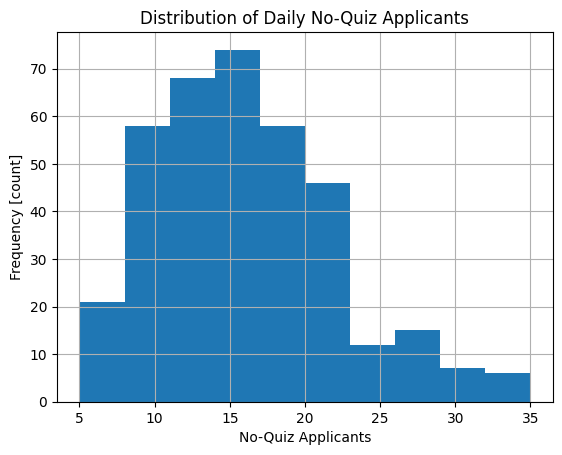

In [35]:
# Create histogram of `no_quiz`
no_quiz_appl.hist()
# Add axis labels and title
plt.xlabel("No-Quiz Applicants")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Daily No-Quiz Applicants");
plt.savefig("images/2.png")
plt.show()

Using the `group_size`, let's determine how many days we must run the experiment so that we have a 95% or greater chance of getting a sufficient number of observations.

In [15]:
prob_65_or_fewer = scipy.stats.norm.cdf(
    group_size*2,
    loc=sum_mean,
    scale=sum_std
)
prob_65_or_greater = 1 - prob_65_or_fewer

print(
    f"Probability of getting 65+ no_quiz in {exp_days} days:",
    round(prob_65_or_greater, 3),
)

Probability of getting 65+ no_quiz in 2 days: 0.0


## Run Experiment

Run the experiment for the number of days.

In [16]:
# from pymongo import MongoClient
# client = MongoClient(host='localhost', port=27017)  # Or your connection string

exp = Experiment(repo=client, db="online_course", collection="applicants")
exp.reset_experiment()
result = exp.run_experiment(days=exp_days, assignment=True)
print("result type:", type(result))
result

Input repo type: <class 'pymongo.synchronous.mongo_client.MongoClient'>
Final client type: <class 'pymongo.synchronous.mongo_client.MongoClient'>
Final collection type: <class 'pymongo.synchronous.collection.Collection'>
Client type: <class 'pymongo.synchronous.mongo_client.MongoClient'>
result type: <class 'dict'>


{'days': 2,
 'total_assigned': 0,
 'daily_results': {'2025-04-05': {'n': 0,
   'n_modified': 0,
   'control_size': 0,
   'treatment_size': 0},
  '2025-04-06': {'n': 0,
   'n_modified': 0,
   'control_size': 0,
   'treatment_size': 0}},
 'statistics': {'control_group': {'total': 0,
   'completed': 0,
   'completion_rate': 0},
  'treatment_group': {'total': 0, 'completed': 0, 'completion_rate': 0},
  'difference': 0}}

In [17]:
import random

# Fetch observations after assignment
observations = repo.find_exp_observations()

# Simulate quiz completion
random.seed(42)  # For reproducibility
for doc in observations:
    if doc['group'] == "No email (control)":
        # 10% completion rate for control group
        if random.random() < 0.1:
            doc['admissionsQuiz'] = "completed"
    elif doc['group'] == "email (treatment)":
        # 20% completion rate for treatment group (email effect)
        if random.random() < 0.2:
            doc['admissionsQuiz'] = "completed"

# Update the database with simulated outcomes
repo.update_applicants(observations)

{'n': 0, 'n_modified': 0}

## Analyze Results

load the observations from the `repo` into a DataFrame `df`.

In [29]:
# 1. Assign applicants to groups
result = repo.assign_to_groups(date_string="2022-01-01")
print(f"Assignment result: {result}")

# 2. Check if assignment worked
debug_result = repo.debug_exp_observations()

# 3. If documents were assigned, proceed with analysis
if debug_result:
    df = pd.DataFrame(debug_result)
    print(f"DataFrame shape after experiment: {df.shape}")

Assignment result: {'n': 18, 'n_modified': 0}
Documents with inExperiment=True: 18
Query returned 18 documents
First document keys: dict_keys(['_id', 'countryISO2', 'createdAt', 'birthday', 'highestDegreeEarned', 'admissionsQuiz', 'group', 'inExperiment'])
DataFrame shape after experiment: (18, 8)


In [19]:
# After running the experiment
repo = MongoRepository()
result = repo.find_exp_observations()

In [20]:
result = repo.find_exp_observations()
debug_result = repo.debug_exp_observations()
df = pd.DataFrame(result)#.dropna(subset=["group", "admissionsQuiz"])
 
print("df type:", type(df))
print("df shape:", df.shape)
df.head()

Documents with inExperiment=True: 18
Query returned 18 documents
First document keys: dict_keys(['_id', 'countryISO2', 'createdAt', 'birthday', 'highestDegreeEarned', 'admissionsQuiz', 'group', 'inExperiment'])
df type: <class 'pandas.core.frame.DataFrame'>
df shape: (18, 8)


,_id,countryISO2,createdAt,birthday,highestDegreeEarned,admissionsQuiz,group,inExperiment
0,67f13b7d17ee46e3dd731fb1,KR,2022-01-01 13:28:44,1988-09-14,Bachelor's degree,incomplete,email (treatment),True
1,67f13b7d17ee46e3dd732167,GB,2022-01-01 13:08:53,1980-04-07,Bachelor's degree,incomplete,email (treatment),True
2,67f13b7d17ee46e3dd732539,IN,2022-01-01 04:46:56,1996-07-19,High School or Baccalaureate,incomplete,email (treatment),True
3,67f13b7d17ee46e3dd73270e,US,2022-01-01 13:36:20,1979-03-04,Bachelor's degree,incomplete,email (treatment),True
4,67f13b7d17ee46e3dd7327bc,FR,2022-01-01 19:45:04,1988-11-17,Bachelor's degree,incomplete,No email (control),True


A `crosstab` of the data in `df`, showing how many applicants in each experimental group did and did not complete the admissions quiz

In [22]:
data = pd.crosstab(
    index=df["group"],
    columns=df["admissionsQuiz"],
    normalize=False
)

print("data type:", type(data))
print("data shape:", data.shape)
data

data type: <class 'pandas.core.frame.DataFrame'>
data shape: (2, 2)


admissionsQuiz,completed,incomplete
group,,
No email (control),1,9
email (treatment),2,9


In [23]:
def build_contingency_bar():
    # Create side-by-side bar chart
    fig = px.bar(
        data_frame=data,
        barmode="group",
        title="Admissions Quiz Completion by Group"
    )
    # Set axis labels
    fig.update_layout(
        xaxis_title="Group",
        yaxis_title="Frequency [count]",
        legend={"title": "Admissions Quiz"}
    )
    return fig


build_contingency_bar().show()

A function that returns side-by-side bar chart of `data`, showing the number of complete and incomplete quizzes for both the treatment and control groups.

In [36]:
# Create `build_contingency_bar` function

# Don't delete the code below 👇
cb_fig = build_contingency_bar()
cb_fig.write_image("images/3.png", scale=1, height=500, width=700)

cb_fig.show()

Instantiate a `Table2x2` object, using the values from the `data`

In [25]:
contingency_table = Table2x2(data.values)

print("contingency_table type:", type(contingency_table))
contingency_table.table_orig

contingency_table type: <class 'statsmodels.stats.contingency_tables.Table2x2'>


array([[1, 9],
       [2, 9]], dtype=int64)

Perform a chi-square test of independence on the `contingency_table`.

In [30]:
chi_square_test = contingency_table.test_nominal_association()

print("chi_square_test type:", type(chi_square_test))
print(chi_square_test)

chi_square_test type: <class 'statsmodels.stats.contingency_tables._Bunch'>
df          1
pvalue      0.5925602769166511
statistic   0.2863636363636363


Calculate the odds ratio for the `contingency_table`.

In [27]:
odds_ratio = contingency_table.oddsratio
print("Odds ratio:", odds_ratio)

Odds ratio: 0.5


In [28]:
summary = contingency_table.summary()
print("summary type:", type(summary))
summary

summary type: <class 'statsmodels.iolib.table.SimpleTable'>


,Estimate,SE,LCB,UCB,p-value
Odds ratio,0.500,,0.038,6.547,0.597
Log odds ratio,-0.693,1.312,-3.265,1.879,0.597
Risk ratio,0.550,,0.058,5.179,0.601
Log risk ratio,-0.598,1.144,-2.840,1.645,0.601
